# Lab1 - Word Sense Disambiguation con Lesk e Embeddings

**Obiettivo**: Implementare una integrazione tra Wordnet ed Embeddings e valutarne l'eventuale efficacia confrontandola con l'algoritmo di lesk nel problema della disambiguazione del senso (Word Sense Disambiguation - WSD) per parole polisemiche.

## 1. Introduzione

Il problema affrontato è la **disambiguazione del senso** (Word Sense Disambiguation - WSD) di una parola in contesto. Le parole naturali sono spesso **polisemiche**, ovvero possiedono più significati distinti a seconda del contesto d'uso.

Ad esempio, la parola "board" può riferirsi a:
- Un gruppo di persone con autorità amministrativa (es. "board of directors")
- Una superficie piatta di legno o materiale simile
- L'azione di salire su un mezzo di trasporto

L'obiettivo della WSD è assegnare automaticamente il **synset** corretto data una parola target e il suo contesto.

### Approcci implementati

In questo laboratorio confrontiamo due metodi complementari:

1. **Lesk (algoritmo classico)**: basato sull'overlap lessicale tra il contesto della frase e le definizioni (gloss) dei synset candidati
2. **Embeddings (approccio moderno)**: utilizza rappresentazioni semantiche dense per calcolare la similarità tra il contesto e le definizioni

Entrambi i metodi verranno valutati su un set di frasi di riferimento per la parola "board" e successivamente sul dataset completo `data/goals.csv`.

In [1]:
# --- blocco: config ---
"""Configurazioni, import e download risorse NLTK."""
from pathlib import Path
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from src.utils import print_code

# Download risorse NLTK (eseguire una sola volta se necessario)
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download("punkt")
nltk.download('punkt_tab')
nltk.download("averaged_perceptron_tagger")
nltk.download('stopwords')

# Stile grafici
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 5)

# Seed per riproducibilita'
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Se stiamo eseguendo lo script (porting da notebook), assicuriamoci che
# esista una funzione `display` compatibile con l'uso in notebook. Se non
# è definita o non è callable, definiamo una semplice versione fallback.
try:
    display
except NameError:
    def display(x):
        print(x)


# Check se PyTorch è disponibile e se usa CUDA
try:
    import torch
    USE_TORCH = True
    USE_CUDA = torch.cuda.is_available()
    DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
    cuda_name = None
    if USE_CUDA:
        try:
            cuda_name = torch.cuda.get_device_name(0)
        except Exception:
            cuda_name = "unknown"
    print(f"PyTorch {torch.__version__} rilevato. \n CUDA disponibile: {USE_CUDA}" + (f" ({cuda_name})" if cuda_name else ""))
except Exception as e:
    USE_TORCH = False
    USE_CUDA = False
    DEVICE = None
    print(f"PyTorch non disponibile ({e.__class__.__name__}): {e}")

print("Setup completato.")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gmammolo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\gmammolo\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gmammolo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\gmammolo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\gmammolo\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gmammolo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is alrea

PyTorch 2.10.0+cu130 rilevato. 
 CUDA disponibile: True (NVIDIA RTX 4000 SFF Ada Generation)
Setup completato.


## 2. Background: WordNet

**WordNet** è un database lessicale (della lingua inglese nel nostro caso) che organizza parole in insiemi di sinonimi chiamati **synset** (synonym sets). Ogni synset rappresenta un concetto lessicale distinto e fornisce:

- **Synset ID**: identificatore univoco (es. `board.n.01`, `board.v.01`)
- **Lemmi**: termini sinonimi che esprimono lo stesso concetto
- **Gloss**: definizione testuale del significato
- **Esempi**: frasi che illustrano l'uso del synset in contesto
- **Relazioni semantiche**:
  - *Iperonimia*: relazione "è-un" verso concetti più generali (es. "board" → "committee")
  - *Iponimia*: relazione inversa verso concetti più specifici
  - *Meronimia/Olonimia*: relazioni parte-tutto

WordNet è la risorsa lessicale di riferimento per la WSD poiché fornisce sia le definizioni necessarie per gli algoritmi basati su overlap (Lesk) sia la struttura semantica per approcci più complessi.

In [2]:
# Esplora la struttura del synset 'board.n.01'
from src.wordnet_helpers import get_synset_structure

synset_name = "board.n.01"
synset_data = get_synset_structure(synset_name)

# Costruisci una tabella pandas con una riga per ogni elemento degli array
rows = []
for k, v in synset_data.items():
    if isinstance(v, (list, tuple)):
        if v:
            for item in v:
                rows.append({'Attribute': k, 'Value': item})
        else:
            rows.append({'Attribute': k, 'Value': ''})
    else:
        rows.append({'Attribute': k, 'Value': v})
df_synset = pd.DataFrame(rows)
display(df_synset)

,Attribute,Value
0,gloss,a committee having supervisory powers
1,lemmas,board
2,examples,the board has seven members
3,hypernyms,committee.n.01
4,hyponyms,draft_board.n.01
5,hyponyms,zoning_board.n.01
6,hyponyms,advisory_board.n.01
7,hyponyms,directorate.n.01
8,hyponyms,federal_reserve_board.n.01
9,hyponyms,school_board.n.01


## 3. Metodologia: Algoritmo di Lesk

L'**algoritmo di Lesk** (1986) è uno dei metodi classici per la WSD, basato su un'ipotesi semplice ma efficace:

> *Il senso corretto di una parola ambigua è quello la cui definizione ha il maggior overlap lessicale con le parole del contesto circostante.*

### Funzionamento

1. **Input**: parola target $w$ e contesto $C$ (frase contenente $w$)
2. **Candidati**: recupera tutti i synset $S = \{s_1, s_2, ..., s_n\}$ associati a $w$ in WordNet
3. **Overlap**: per ogni synset $s_i$, calcola l'overlap tra:
   - Le parole del contesto $C$
   - Le parole della definizione (gloss) di $s_i$
4. **Selezione**: restituisce il synset $s^* = \arg\max_{s_i \in S} \text{overlap}(C, \text{gloss}(s_i))$

In questo laboratorio si userà la variante implementata in NLTK

In [3]:
# --- blocco: wordnet_helpers ---
from src.lesk import lesk_disambiguate


print_code(lesk_disambiguate)


def lesk_disambiguate(word, sentence, pos=None):
    try:
        tokens = word_tokenize(sentence)
        filtered_tokens = [t for t in tokens if t not in stop_words]
        synset = lesk(filtered_tokens, word, pos=pos)
        return (synset.name() if synset else None, 0.0)
    except Exception as e:
        import traceback
        print('Lesk disambiguate exception occurred:', repr(e))
        traceback.print_exc()
        return (None, 0.0)


Procediamo dunque a provare l algoritmo davanti a una parola con molti significati polisemici: la famigerata parola `board`:

In [4]:
# Frasi di riferimento con gold standard
board_sentences = [
    ("Money for its construction will be sought later_on but in_the_meantime the State_Hospital board can accept gifts and donations of a site.", "board.n.01"),
    ("Under Formby 's plan, an appointee would be selected by a board composed of the governor, lieutenant_governor, speaker of the House, attorney_general and chief_justice of the Texas_Supreme_Court.", "board.n.01"),
    ("He just shot at the board and_then drew circles around the holes to form a bull's-eye.", "board.n.02"),
    ("This is in contrast to the family with whom he boards.", "board.v.02"),
    ("She usually wore weeds, and a stranger watching her board a train might have guessed that Mr._Pastern was dead, but Mr._Pastern was far from dead.", "board.v.01"),
    ('"His head hung over the boards of Katie \'s stall; before it was sprawled the mangled corpse of the bearded stranger."', "board.n.03"),
]

print("=== TEST LESK SU BOARD_SENTENCES ===\n")
lesk_results = []
for sent, gold_synset in board_sentences:
    pred_tuple = lesk_disambiguate("board", sent)
    pred = pred_tuple[0] if isinstance(pred_tuple, tuple) else pred_tuple
    match = "✓" if pred == gold_synset else "✗"
    lesk_results.append((sent, gold_synset, pred, match))
    print(f"Sentence: {sent}")
    print(f"{match} Gold: {gold_synset:12} | Pred: {pred or 'NONE'}")

# Calcola accuratezza
lesk_correct = sum(1 for _, gold, pred, _ in lesk_results if gold == pred)
lesk_accuracy = lesk_correct / len(lesk_results)
print(f"\nAccuratezza Lesk: {lesk_accuracy:.1%} ({lesk_correct}/{len(lesk_results)})")

=== TEST LESK SU BOARD_SENTENCES ===

Sentence: Money for its construction will be sought later_on but in_the_meantime the State_Hospital board can accept gifts and donations of a site.
✗ Gold: board.n.01   | Pred: board.n.09
Sentence: Under Formby 's plan, an appointee would be selected by a board composed of the governor, lieutenant_governor, speaker of the House, attorney_general and chief_justice of the Texas_Supreme_Court.
✗ Gold: board.n.01   | Pred: board.n.09
Sentence: He just shot at the board and_then drew circles around the holes to form a bull's-eye.
✗ Gold: board.n.02   | Pred: board.n.09
Sentence: This is in contrast to the family with whom he boards.
✗ Gold: board.v.02   | Pred: board.n.01
Sentence: She usually wore weeds, and a stranger watching her board a train might have guessed that Mr._Pastern was dead, but Mr._Pastern was far from dead.
✗ Gold: board.v.01   | Pred: board.n.09
Sentence: "His head hung over the boards of Katie 's stall; before it was sprawled the ma

Sicuramente esistono ulteriori ottimizzazioni che possono far funzionare lesk in maniera più performante.
l'algoritmo in questione ha già avuto un miglioramento con l'uso delle stop words, migliorando un po il risultato (precedentemente trovava riferimenti a `circuit_board`) ma tale ottimizzazione non è in grado di aiutarlo a disembiguare le frasi proposte. 

## 4. Metodologia: WSD con Embeddings

Gli **embeddings** sono rappresentazioni vettoriali dense che catturano il significato semantico di testi in uno spazio continuo ad alta dimensionalità. A differenza di Lesk, questo approccio non richiede overlap lessicale esplicito.

### Funzionamento

1. **Encoding**: usa un modello pre-addestrato per generare:
   - $\vec{e}_{\text{sent}}$: embedding della frase contenente la parola target
   - $\vec{e}_{s_i}$: embedding della definizione (gloss + esempi) di ogni synset candidato $s_i$

2. **Similarità**: calcola la similarità coseno tra i vettori:
   $$
   \text{sim}(s_i) = \frac{\vec{e}_{\text{sent}} \cdot \vec{e}_{s_i}}{\|\vec{e}_{\text{sent}}\| \|\vec{e}_{s_i}\|}
   $$

3. **Selezione**: restituisce il synset con massima similarità:
   $$
   s^* = \arg\max_{s_i \in S} \text{sim}(s_i)
   $$

### Modello utilizzato

In questo esperimento sono stati utilizzati vari modelli.
Inizialmente era stato usato `all-MiniLM-L6-v2` (Sentence-Transformers).
In una seconda fare di ottimizzazione si è passati ad un modello più grande e performante: `all-mpnet-base-v2`.


In [5]:
# --- blocco: embeddings ---
"""Importa helper embeddings da src e stampa il codice delle funzioni."""
from src.embeddings import embed_disambiguate
from src.utils import print_code

# Stampa il codice sorgente di `embed_disambiguate` definita in src/embeddings.py
print_code(embed_disambiguate)


def embed_disambiguate(word: str, sentence: str, pos=None, model_name: str='all-MiniLM-L6-v2') -> List[tuple]:
    model = get_embedding_model(model_name)
    try:
        candidates = wn.synsets(word, pos=pos)
        if not candidates:
            return []
        synset_texts = [_build_synset_text(c, include_examples=False, include_related=False) for c in candidates]
        synset_texts += [_build_synset_text(c, include_examples=True, include_related=False) for c in candidates]
        synset_texts += [_build_synset_text(c, include_examples=True, include_related=True) for c in candidates]
        gloss_embs = model.encode(synset_texts)
        sent_emb = model.encode(sentence)
        sims = cosine_similarity([sent_emb], gloss_embs)[0]
        idx = np.argmax(sims)
        rnd = idx // len(candidates)
        idx_in_block = idx % len(candidates)
        return [candidates[idx_in_block].name(), float(sims[idx]), rnd]
    except Exception as e:
        import traceback
        print

In [6]:
print("=== TEST EMBEDDINGS SU BOARD_SENTENCES ===\n")
embeddings_results = []
emb_model_name="all-mpnet-base-v2"
for sent, gold_synset in board_sentences:
    candidate = embed_disambiguate("board", sent, model_name=emb_model_name)
    pred = candidate[0]
    rnd = candidate[2]
    match = "✓" if pred == gold_synset else "✗"
    embeddings_results.append((sent, gold_synset, pred, match, rnd))
    print(f"Sentence: {sent}")
    print(f"{match} Gold: {gold_synset:12} | Pred: {pred}")
    

# Calcola accuratezza
embeddings_correct = sum(1 for _, gold, pred, _, _ in embeddings_results if gold == pred)
embeddings_accuracy = embeddings_correct / len(embeddings_results)
print(f"\nAccuratezza Embeddings: {embeddings_accuracy:.1%} ({embeddings_correct}/{len(embeddings_results)})")


=== TEST EMBEDDINGS SU BOARD_SENTENCES ===

Sentence: Money for its construction will be sought later_on but in_the_meantime the State_Hospital board can accept gifts and donations of a site.
✗ Gold: board.n.01   | Pred: board.v.04
Sentence: Under Formby 's plan, an appointee would be selected by a board composed of the governor, lieutenant_governor, speaker of the House, attorney_general and chief_justice of the Texas_Supreme_Court.
✓ Gold: board.n.01   | Pred: board.n.01
Sentence: He just shot at the board and_then drew circles around the holes to form a bull's-eye.
✗ Gold: board.n.02   | Pred: board.n.09
Sentence: This is in contrast to the family with whom he boards.
✓ Gold: board.v.02   | Pred: board.v.02
Sentence: She usually wore weeds, and a stranger watching her board a train might have guessed that Mr._Pastern was dead, but Mr._Pastern was far from dead.
✗ Gold: board.v.01   | Pred: board.v.03
Sentence: "His head hung over the boards of Katie 's stall; before it was sprawled 

In [7]:
print("\n" + "="*60)
print(f"CONFRONTO su board_sentences:")
print(f"  Lesk:                       {lesk_accuracy:.1%}")
print(f"  Embeddings:                 {embeddings_accuracy:.1%}")
print("="*60)




CONFRONTO su board_sentences:
  Lesk:                       0.0%
  Embeddings:                 33.3%


### embedding text

Ci sono varie possibilità per creare gli embeddings dei synset:
- Solo definizione (gloss)
- Definizione + esempi  
- Definizione + esempi + contesto della frase target

Quale è la migliore combinazione? 
Per scoprirlo, nel calcolo degli embeddings dei synset, anzichè caricare solo n synset nel modello, si caricano 3*synset diverse righe da encodificare.
L'idea è di vedere, una volta calcolate le similarità, quale delle 3 righe ha portato al synset con lo score più alto.

In [8]:
print(f"definition                         {len([r for r in embeddings_results if r[4]==0 and r[3]=='✓'])}/{len(embeddings_results)} correct (tot. {len([r for r in embeddings_results if r[4]==0])}) ")
print(f"definition + examples:             {len([r for r in embeddings_results if r[4]==1 and r[3]=='✓'])}/{len(embeddings_results)} correct (tot. {len([r for r in embeddings_results if r[4]==1])}) ")
print(f"definition + examples + related:   {len([r for r in embeddings_results if r[4]==2 and r[3]=='✓'])}/{len(embeddings_results)} correct (tot. {len([r for r in embeddings_results if r[4]==2])}) ")
print("="*60)

definition                         1/6 correct (tot. 2) 
definition + examples:             1/6 correct (tot. 3) 
definition + examples + related:   0/6 correct (tot. 1) 


da questo primo esempio possiamo vedere che l'approccio con embeddings sembra funzionare meglio di lesk, anche se non perfettamente.
Inoltre, sembra che l'approccio con embeddings che utilizza la gloss+esempi (riga 2) sia quello che funziona meglio.
Tuttavia son pochi dati per trarre conclusioni definitive. Verificheremo  su un dataset completo.

## 5. Valutazione su Dataset Completo (goals.csv)

Applichiamo entrambi i metodi al dataset `data/goals.csv`, che contiene frasi annotate con diverse parole target (non solo "board"). 

Il database è stato estrapolato da SemCor, con l'estrazione di tutti i termini che hanno più di un synset


In [9]:
import csv
from src.utils import ensure_dir

# Carica goals.csv
goals_path = "data/goals.csv"
ensure_dir("outputs")

# DEBUG_LIMIT per testing veloce (impostare a None per elaborare tutto)
DEBUG_LIMIT = 10000

df_goals = pd.read_csv(goals_path, sep=";", encoding="utf-8")
print(f"Caricate {len(df_goals)} righe da {goals_path}")

# Limita a DEBUG_LIMIT per testing
df_goals_limited = df_goals.head(DEBUG_LIMIT) if DEBUG_LIMIT else df_goals
print(f"Elaborando {len(df_goals_limited)} righe (DEBUG_LIMIT={DEBUG_LIMIT})\n")

# Salva risultati in CSV
output_path = "outputs/lab1_score_comparison.csv"

if not Path(output_path).exists():
    results = []
    for idx, row in df_goals_limited.iterrows():
        word = row["parola"].strip()
        sentence = row["frase"].strip()
        gold_synset = row["synset"].strip()
        
        # Applica Lesk
        lesk_result = lesk_disambiguate(word, sentence)
        lesk_pred = lesk_result[0] if isinstance(lesk_result, tuple) else lesk_result
        
        # Applica Embeddings (base)
        try:
            embeddings_candidate = embed_disambiguate(word, sentence, model_name=emb_model_name)
            embeddings_pred = embeddings_candidate[0]
        except Exception as e:
            embeddings_pred = f"ERROR: {str(e)[:30]}"
        
        # Determina note
        lesk_match = "✓" if lesk_pred == gold_synset else "✗"
        emb_match = "✓" if embeddings_pred == gold_synset else "✗"
        emb_rnd = embeddings_candidate[2]
        
        results.append({
            "parola": word,
            "frase": sentence[:100],  # Tronca per leggibilità
            "gold_synset": gold_synset,
            "lesk_pred": lesk_pred or "NONE",
            "embeddings_pred": embeddings_pred,
            "embeddings_rnd": emb_rnd
        })
        
        if (idx + 1) % 100 == 0:
            print(f"Elaborati {idx + 1}/{len(df_goals_limited)} righe...")

    # Salva su CSV
    with open(output_path, "w", newline="", encoding="utf-8") as csvfile:
        fieldnames = [
            "parola",
            "frase",
            "gold_synset",
            "lesk_pred",
            "embeddings_pred",
            "embeddings_rnd",
        ]
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames, delimiter=";")
        writer.writeheader()
        writer.writerows(results)

    print(f"\n✓ Risultati salvati in {output_path} ({len(results)} righe)")
    
else:
    print(f"✓ Il file {output_path} esiste già. Saltata l'elaborazione.")
    print("Per rieseguire l'elaborazione, elimina o rinomina il file esistente.")

Caricate 175323 righe da data/goals.csv
Elaborando 10000 righe (DEBUG_LIMIT=10000)

Elaborati 100/10000 righe...
Elaborati 200/10000 righe...
Elaborati 300/10000 righe...
Elaborati 400/10000 righe...
Elaborati 500/10000 righe...
Elaborati 600/10000 righe...
Elaborati 700/10000 righe...
Elaborati 800/10000 righe...
Elaborati 900/10000 righe...
Elaborati 1000/10000 righe...
Elaborati 1100/10000 righe...
Elaborati 1200/10000 righe...
Elaborati 1300/10000 righe...
Elaborati 1400/10000 righe...
Elaborati 1500/10000 righe...
Elaborati 1600/10000 righe...
Elaborati 1700/10000 righe...
Elaborati 1800/10000 righe...
Elaborati 1900/10000 righe...
Elaborati 2000/10000 righe...
Elaborati 2100/10000 righe...
Elaborati 2200/10000 righe...
Elaborati 2300/10000 righe...
Elaborati 2400/10000 righe...
Elaborati 2500/10000 righe...
Elaborati 2600/10000 righe...
Elaborati 2700/10000 righe...
Elaborati 2800/10000 righe...
Elaborati 2900/10000 righe...
Elaborati 3000/10000 righe...
Elaborati 3100/10000 righ

## 9. Risultati e Confronto

Carichiamo i risultati salvati e calcoliamo le metriche di accuratezza per entrambi i metodi.


  RISULTATI COMPARATIVI SU GOALS.CSV (Dataset Completo)
    Metodo  Corretti  Totali Accuratezza
      Lesk      3622   10000       36.2%
Embeddings      3137   10000       31.4%


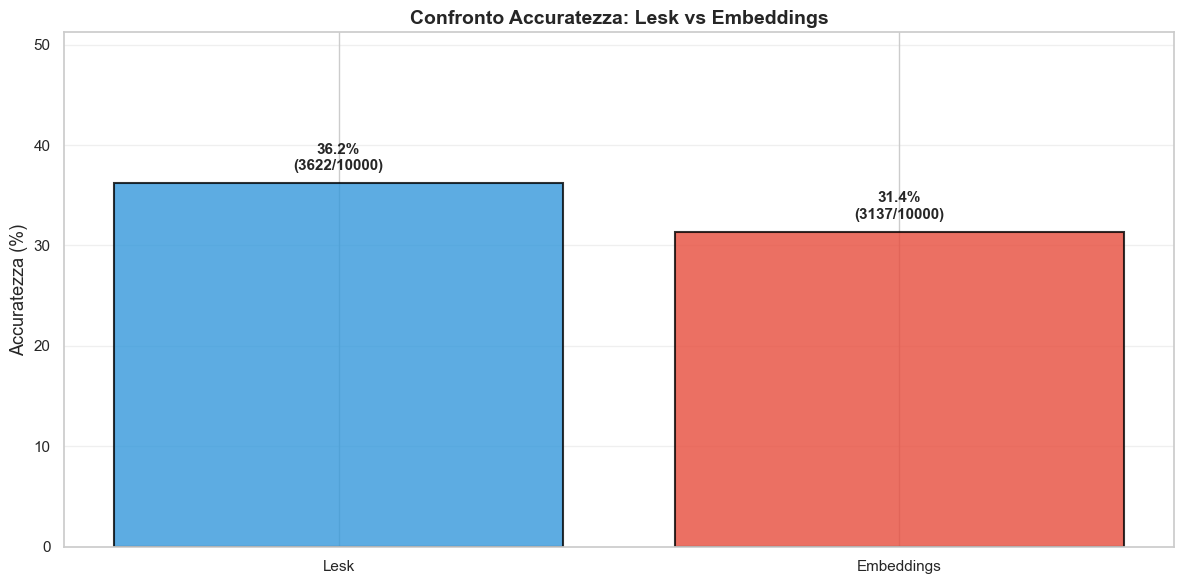


Dataset elaborato: 10000 frasi valide (DEBUG_LIMIT=10000)

Migliore metodo: Lesk con accuratezza 36.2%


In [10]:
# Carica risultati e calcola accuratezza
df_results = pd.read_csv(output_path, sep=";", encoding="utf-8")

# Filtra righe con gold_synset valido
df_valid = df_results[df_results["gold_synset"].notna() & (df_results["gold_synset"] != "")]

lesk_correct = (df_valid["lesk_pred"] == df_valid["gold_synset"]).sum()
embeddings_correct = (df_valid["embeddings_pred"] == df_valid["gold_synset"]).sum()
total_valid = len(df_valid)

lesk_accuracy = lesk_correct / total_valid if total_valid > 0 else 0
embeddings_accuracy = embeddings_correct / total_valid if total_valid > 0 else 0

# Tabella riassuntiva
summary_data = {
    "Metodo": ["Lesk", "Embeddings"],
    "Corretti": [lesk_correct, embeddings_correct],
    "Totali": [total_valid, total_valid],
    "Accuratezza": [f"{lesk_accuracy:.1%}", f"{embeddings_accuracy:.1%}"]
}
df_summary = pd.DataFrame(summary_data)
print("\n" + "="*70)
print("  RISULTATI COMPARATIVI SU GOALS.CSV (Dataset Completo)")
print("="*70)
print(df_summary.to_string(index=False))
print("="*70)

# Visualizzazione bar chart con i metodi
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
methods = ["Lesk", "Embeddings"]
accuracies = [lesk_accuracy * 100, embeddings_accuracy * 100]
colors = ["#3498db", "#e74c3c"]
bars = ax.bar(methods, accuracies, color=colors, alpha=0.8, edgecolor="black", linewidth=1.5)

# Aggiungi valori sopra le barre
for bar, acc, correct in zip(bars, accuracies, [lesk_correct, embeddings_correct]):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{acc:.1f}%\n({correct}/{total_valid})',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_ylabel("Accuratezza (%)", fontsize=13)
ax.set_title("Confronto Accuratezza: Lesk vs Embeddings", fontsize=14, fontweight='bold')
ax.set_ylim(0, max(accuracies) + 15)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nDataset elaborato: {total_valid} frasi valide (DEBUG_LIMIT={DEBUG_LIMIT})")
print(f"\nMigliore metodo: {summary_data['Metodo'][np.argmax(accuracies)]} con accuratezza {max(accuracies):.1f}%")

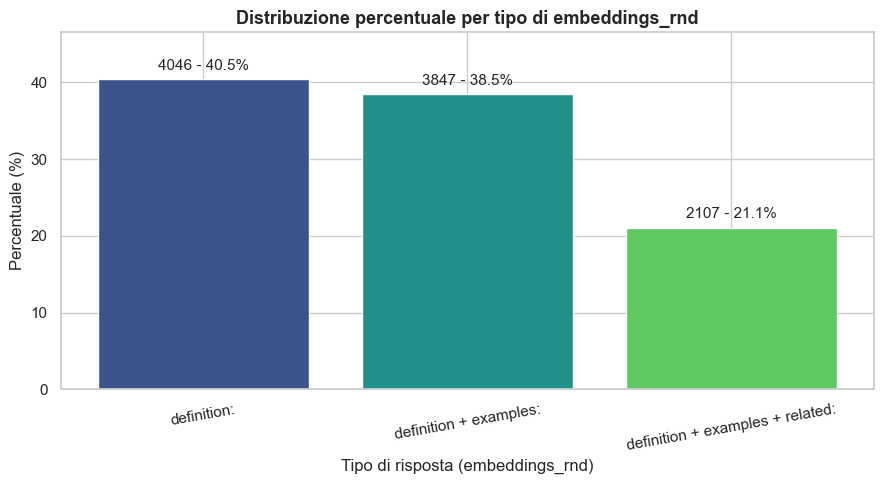

In [11]:
# Plot: conteggio risposte per 'embeddings_rnd' con label personalizzati
# Usa df_results (caricato nella cella precedente) per contare i tipi di risposta
try:
    counts = df_results['embeddings_rnd'].value_counts().sort_index()
except Exception:
    # In caso df_results non sia presente, ricarichiamolo dal file di output
    df_results = pd.read_csv(output_path, sep=';', encoding='utf-8')
    counts = df_results['embeddings_rnd'].value_counts().sort_index()

# Mappa i codici a label richiesti
label_map = {0: 'definition:', 1: 'definition + examples:', 2: 'definition + examples + related:'}
# Costruisci le etichette nell'ordine dei counts.index
try:
    x_labels = [label_map.get(int(x), str(x)) for x in counts.index]
except Exception:
    x_labels = [label_map.get(x, str(x)) for x in counts.index]

# Mostra il plot: barre rappresentano percentuali (y in %), annotazioni mostrano 'tot - %'
fig, ax = plt.subplots(figsize=(9, 5))
# Usa una palette per i colori
colors = sns.color_palette('viridis', len(counts))
# Calcola totale e percentuali
total = counts.values.sum() if hasattr(counts.values, 'sum') else sum(counts.values)
pcts = (counts.values / total * 100) if total else np.zeros_like(counts.values)
# Disegna barre basate sulle percentuali
ax.bar(range(len(counts)), pcts, color=colors)
ax.set_xticks(range(len(counts)))
ax.set_xticklabels(x_labels)
ax.set_xlabel('Tipo di risposta (embeddings_rnd)', fontsize=12)
ax.set_ylabel('Percentuale (%)', fontsize=12)
ax.set_title('Distribuzione percentuale per tipo di embeddings_rnd', fontsize=13, fontweight='bold')
# Annotazioni: mostra 'tot - %' sopra ogni barra
for i, (v, pct) in enumerate(zip(counts.values, pcts)):
    label = f"{int(v)} - {pct:.1f}%"
    ax.text(i, pct + max(pcts) * 0.02, label, ha='center', va='bottom', fontsize=11)
# Adatta y-limit leggermente sopra il massimo percentuale
ax.set_ylim(0, max(pcts) * 1.15 if len(pcts) else 1)
plt.xticks(rotation=10)
plt.tight_layout()
plt.show()

## 10. Conclusioni

Questo laboratorio ha confrontato due approcci alla Word Sense Disambiguation: l'algoritmo classico di Lesk (basato su overlap lessicale) e un metodo moderno basato su embeddings (rappresentazioni semantiche dense).


### Risultati

Il risultato più sorprendente di questo esperimento è che **Lesk performa meglio degli embeddings sul dataset completo**, nonostante gli embeddings abbiano dominato sul subset di test con "board". Questo risultato controintuitivo merita un'analisi approfondita. 

1. **Overfitting del modello embedding al training**: i modelli Sentence-Transformers sono pre-addestrati su corpus generali ma potrebbero non catturare le sfumature lessicografiche specifiche di WordNet, mentre Lesk lavora direttamente con le definizioni di WordNet.

2. **Sensibilità al contesto semantico vs lessicale**: gli embeddings potrebbero confondere sensi semanticamente vicini ma lessicalmente distinti. Lesk, basandosi su overlap esplicito di parole, è più "letterale" e potrebbe essere più affidabile quando le definizioni di WordNet contengono termini distintivi.

3. **Qualità delle gloss in WordNet**: per molti synset comuni (frequenti in SemCor), le definizioni potrebbero contenere termini tecnici o distintivi che favoriscono l'overlap lessicale.

4. **Complementarità degli approcci**: nessuno dei due metodi domina in modo assoluto. Si potrebbe pensare a combinazioni ibride (o sistemi di fallback). Anche se quest'ultimo potrebbe non essere cosi facile da implementare in quanto la difficoltà sta proprio nel non avere facilmente un feedback sulla correttezza.

### Limiti dello studio

- **Modello fisso**: è stato usato un solo modello di embeddings (`all-mpnet-base-v2`). Modelli specializzati per WSD o fine-tuned su WordNet potrebbero performare meglio.
- **Mancanza di ottimizzazione Lesk**: la versione di Lesk usata è quella base di NLTK; varianti ottimizzate (extended Lesk, adapted Lesk) potrebbero migliorare ulteriormente le performance.